In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

# テスト用回路の生成

In [2]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter

def generate_2qubit_qnn(label):
    circuit = QuantumCircuit(2)
    circuit.ry(np.pi / 4.0, 0)
    circuit.ry(np.pi / 4.0, 1)

    circuit.barrier()
    for i in range(2):
        if label[i] == 'x':
            circuit.rx(Parameter('theta'+str(i)), i)
        elif label[i] == 'y':
            circuit.ry(Parameter('theta'+str(i)), i)
        elif label[i] == 'z':
            circuit.rz(Parameter('theta'+str(i)), i) 
    circuit.barrier()

    # Add CZ ladder.
    circuit.cz(0, 1)

    return circuit

<IPython.core.display.Javascript object>


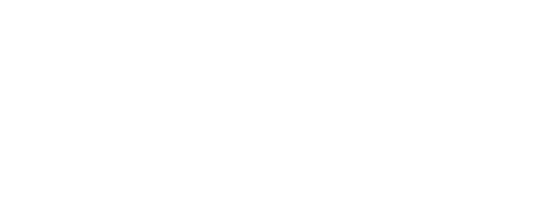

<IPython.core.display.Javascript object>


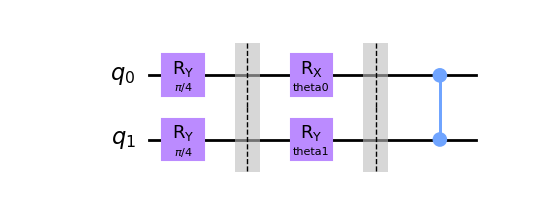

In [3]:
qc_test = generate_2qubit_qnn('xy')
qc_test.draw('mpl')

# 期待値の評価

In [4]:
# 期待値の計算
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.opflow import CircuitSampler, StateFn, PauliSumOp
from qiskit.opflow.expectations import PauliExpectation

hamiltonian = PauliSumOp.from_list([('X', 1.0)])

expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(qc_test)
aerpauli_basis = PauliExpectation().convert(expectation)

quantum_instance = QuantumInstance(Aer.get_backend('qasm_simulator'),
                                  shots = 32768)
sampler = CircuitSampler(quantum_instance)

# 期待値の評価
def calculate_exp_val(params):
  value_dict = dict(zip(qc_test.parameters, params))
  result = sampler.convert(aerpauli_basis, params=value_dict).eval()
  return np.real(result)

<IPython.core.display.Javascript object>


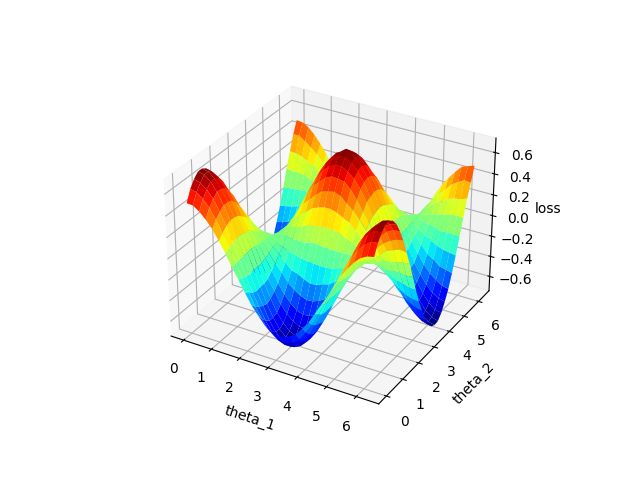

In [5]:
X = np.linspace(0, 2*np.pi, 30)
Y = np.linspace(0, 2*np.pi, 30)
Z = np.array([[calculate_exp_val([x, y]) for x in X] for y in Y]).reshape(len(Y), len(X))

xx, yy = np.meshgrid(X, Y)
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot_surface(xx, yy, Z, cmap=plt.cm.jet)
ax.set_xlabel('theta_1')
ax.set_ylabel('theta_2')
ax.set_zlabel('loss')

plt.show()

# 勾配(vanilla gradient)の評価

In [6]:
from qiskit.opflow import Gradient

gradient = Gradient().convert(expectation)
gradient_in_pauli_basis = PauliExpectation().convert(gradient)

# 勾配の評価
def calculate_gradient(params):
  value_dict = dict(zip(qc_test.parameters, params))
  result = sampler.convert(gradient_in_pauli_basis, params=value_dict).eval()
  return np.real(result)

# 自然勾配の評価

In [7]:
from qiskit.opflow import NaturalGradient

ng = NaturalGradient().convert(expectation)
ng_in_pauli_basis = PauliExpectation().convert(ng)

def calculate_natural_gradient(params):
  value_dict = dict(zip(qc_test.parameters, params))
  result = sampler.convert(ng_in_pauli_basis, params=value_dict).eval()
  return np.real(result)

# 初期地点の定義

In [8]:
initial_point = np.array([np.pi, np.pi])

# 最適化計算

## 最急降下法

In [9]:
from qiskit.algorithms.optimizers import GradientDescent

gd_loss= []
xx_op= []
yy_op= []
def gd_callback(nfevs, x, fx, stepsize):
  gd_loss.append(fx)
  xx_op.append(x[0])
  yy_op.append(x[1])

gd = GradientDescent(maxiter=50,learning_rate=0.1, callback=gd_callback)

x_opt, fx_opt, nfevs = (
  gd.optimize(initial_point.size,
                calculate_exp_val,
                gradient_function=calculate_gradient,
                initial_point=initial_point)
)

In [10]:
ngd_loss= []
xx_op_ng= []
yy_op_ng= []
def ngd_callback(nfevs, x, fx, stepsize):
  ngd_loss.append(fx)
  xx_op_ng.append(x[0])
  yy_op_ng.append(x[1])

qng = GradientDescent(maxiter=50,learning_rate=0.1, callback=ngd_callback)

x_opt_ng, fx_opt_ng, nfevs_ng = (
  qng.optimize(initial_point.size,
                calculate_exp_val,
                gradient_function=calculate_natural_gradient,
                initial_point=initial_point)
)

# 結果のプロット

<IPython.core.display.Javascript object>


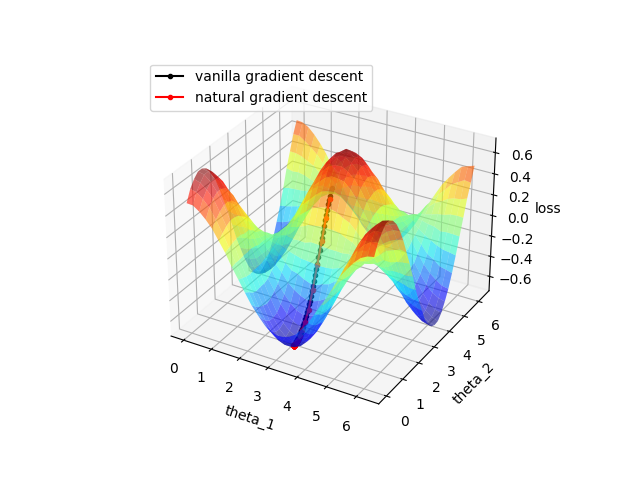

In [11]:
from matplotlib.animation import FuncAnimation

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot_surface(xx, yy, Z, cmap=plt.cm.jet, alpha=0.6)
gd, = ax.plot([], [], [], '.-k', label='vanilla gradient descent')
ngd, = ax.plot([], [], [], '.-r', label='natural gradient descent')

ax.set_xlabel('theta_1')
ax.set_ylabel('theta_2')
ax.set_zlabel('loss')

def update(f):
    gd.set_data(xx_op[:f], yy_op[:f])
    gd.set_3d_properties(gd_loss[:f])
    ngd.set_data(xx_op_ng[:f], yy_op_ng[:f])
    ngd.set_3d_properties(ngd_loss[:f])
    
anim = FuncAnimation(fig, update, interval=200)

plt.legend(loc='upper left')
plt.show()

In [12]:
anim.save("ngd.gif")

MovieWriter ffmpeg unavailable; using Pillow instead.


In [13]:
import qiskit.tools.jupyter
%qiskit_version_table